<a href="https://colab.research.google.com/github/martiche93/The-Cancer-Wizards/blob/carleybranch/Tryptase_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install conda and rdkit**

INTENTION OF THIS NOTEBOOK: Compute molecular descriptors and then perform exploratory data analysis on these descriptors.

RDKit allows the computation of the molecular descriptors for the compounds in the compiled dataset (tryptase_bioactivity_preprocessed_data.csv).

This dataset shows the biological activity data from the ChEMBL database for the specific tryptase protein, and is comprised of the molecular names and the corresponding SMILES notation (information about the chemical structure). This information will be used in this notebook to compute the molecular descriptors. 

The dataset also includes the IC50 (the half maximal inhibitory concentration (IC50) is a measure of the potency of a substance in inhibiting a specific biological or biochemical function), which has been binned into 3 categories: active (<= 1000), inactive (>= 10,000), and intermediate (all values in between). For this analysis, we will only be comparing the inactive and the active compounds. 

In [2]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-08-22 19:11:10--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’

Miniconda3-py37_4.8 100%[===================>]  81.12M   108MB/s    in 0.8s    

2021-08-22 19:11:11 (108 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ | / - \ | / - \ | / failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / - \ | / - \ | / 

## **Load bioactivity data**

In [3]:
import pandas as pd

In [13]:
tryptase_df = pd.read_csv('tryptase_bioactivity_preprocessed_data.csv')

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

Basically: Can these compounds be absorbed into the body, distributed to the tissue/organs, become metabolized, and then eventually excreted out of the body. 

### **Import libraries**

In [6]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [21]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [16]:
df_lipinski = lipinski(df.canonical_smiles)

### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [17]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,494.593,1.05827,3.0,6.0
1,508.620,1.44837,3.0,6.0
2,508.620,1.44837,3.0,6.0
3,546.713,2.68857,3.0,5.0
4,508.620,1.44837,3.0,6.0
...,...,...,...,...
162,464.610,3.09980,3.0,4.0
163,484.600,3.60440,3.0,4.0
164,484.600,3.48570,3.0,4.0
165,361.785,1.84960,1.0,6.0


In [18]:
tryptase_df

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value
0,CHEMBL432835,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCN(C(...,active,9.0
1,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,71.0
2,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,204.0
3,CHEMBL109504,N=C(N)N1CCCC(C[C@H]2C(=O)N(C(=O)N3CCN(C(=O)CCC...,active,1.9
4,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,63.0
...,...,...,...,...
162,CHEMBL107226,NCCCCCCNC(=O)CN1CCCCC(NC(=O)c2ccc(-c3ccccc3)cc...,inactive,33000.0
163,CHEMBL326694,NCCc1ccc(NC(=O)CN2CCCCC(NC(=O)c3ccc(-c4ccccc4)...,inactive,11000.0
164,CHEMBL320473,NCc1cccc(NC(=O)CN2CCCCC(NC(=O)c3ccc(Cc4ccccc4)...,active,980.0
165,CHEMBL3604626,CN1C(=O)c2ccc(OC(=O)CCc3ccc(N)nc3)cc2C1=O.Cl,active,190.0


Now, let's combine the 2 DataFrame

In [19]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [20]:
df_combined

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL432835,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCN(C(...,active,9.0,494.593,1.05827,3.0,6.0
1,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,71.0,508.620,1.44837,3.0,6.0
2,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,204.0,508.620,1.44837,3.0,6.0
3,CHEMBL109504,N=C(N)N1CCCC(C[C@H]2C(=O)N(C(=O)N3CCN(C(=O)CCC...,active,1.9,546.713,2.68857,3.0,5.0
4,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,63.0,508.620,1.44837,3.0,6.0
...,...,...,...,...,...,...,...,...
162,CHEMBL107226,NCCCCCCNC(=O)CN1CCCCC(NC(=O)c2ccc(-c3ccccc3)cc...,inactive,33000.0,464.610,3.09980,3.0,4.0
163,CHEMBL326694,NCCc1ccc(NC(=O)CN2CCCCC(NC(=O)c3ccc(-c4ccccc4)...,inactive,11000.0,484.600,3.60440,3.0,4.0
164,CHEMBL320473,NCc1cccc(NC(=O)CN2CCCCC(NC(=O)c3ccc(Cc4ccccc4)...,active,980.0,484.600,3.48570,3.0,4.0
165,CHEMBL3604626,CN1C(=O)c2ccc(OC(=O)CCc3ccc(N)nc3)cc2C1=O.Cl,active,190.0,361.785,1.84960,1.0,6.0


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [22]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [23]:
df_combined.standard_value.describe()

count      167.000000
mean      4195.608383
std       9868.343512
min          0.400000
25%          5.100000
50%         61.000000
75%        925.000000
max      33000.000000
Name: standard_value, dtype: float64

In [24]:
-np.log10( (10**-9)* 100000000 )

1.0

In [25]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [26]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [27]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL432835,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCN(C(...,active,494.593,1.05827,3.0,6.0,9.0
1,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,508.620,1.44837,3.0,6.0,71.0
2,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,508.620,1.44837,3.0,6.0,204.0
3,CHEMBL109504,N=C(N)N1CCCC(C[C@H]2C(=O)N(C(=O)N3CCN(C(=O)CCC...,active,546.713,2.68857,3.0,5.0,1.9
4,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,508.620,1.44837,3.0,6.0,63.0
...,...,...,...,...,...,...,...,...
162,CHEMBL107226,NCCCCCCNC(=O)CN1CCCCC(NC(=O)c2ccc(-c3ccccc3)cc...,inactive,464.610,3.09980,3.0,4.0,33000.0
163,CHEMBL326694,NCCc1ccc(NC(=O)CN2CCCCC(NC(=O)c3ccc(-c4ccccc4)...,inactive,484.600,3.60440,3.0,4.0,11000.0
164,CHEMBL320473,NCc1cccc(NC(=O)CN2CCCCC(NC(=O)c3ccc(Cc4ccccc4)...,active,484.600,3.48570,3.0,4.0,980.0
165,CHEMBL3604626,CN1C(=O)c2ccc(OC(=O)CCc3ccc(N)nc3)cc2C1=O.Cl,active,361.785,1.84960,1.0,6.0,190.0


In [28]:
df_norm.standard_value_norm.describe()

count      167.000000
mean      4195.608383
std       9868.343512
min          0.400000
25%          5.100000
50%         61.000000
75%        925.000000
max      33000.000000
Name: standard_value_norm, dtype: float64

In [29]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL432835,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCN(C(...,active,494.593,1.05827,3.0,6.0,8.045757
1,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,508.620,1.44837,3.0,6.0,7.148742
2,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,508.620,1.44837,3.0,6.0,6.690370
3,CHEMBL109504,N=C(N)N1CCCC(C[C@H]2C(=O)N(C(=O)N3CCN(C(=O)CCC...,active,546.713,2.68857,3.0,5.0,8.721246
4,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,508.620,1.44837,3.0,6.0,7.200659
...,...,...,...,...,...,...,...,...
162,CHEMBL107226,NCCCCCCNC(=O)CN1CCCCC(NC(=O)c2ccc(-c3ccccc3)cc...,inactive,464.610,3.09980,3.0,4.0,4.481486
163,CHEMBL326694,NCCc1ccc(NC(=O)CN2CCCCC(NC(=O)c3ccc(-c4ccccc4)...,inactive,484.600,3.60440,3.0,4.0,4.958607
164,CHEMBL320473,NCc1cccc(NC(=O)CN2CCCCC(NC(=O)c3ccc(Cc4ccccc4)...,active,484.600,3.48570,3.0,4.0,6.008774
165,CHEMBL3604626,CN1C(=O)c2ccc(OC(=O)CCc3ccc(N)nc3)cc2C1=O.Cl,active,361.785,1.84960,1.0,6.0,6.721246


In [30]:
df_final.pIC50.describe()

count    167.000000
mean       7.053112
std        1.419562
min        4.481486
25%        6.034017
50%        7.214670
75%        8.292513
max        9.397940
Name: pIC50, dtype: float64

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [31]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL432835,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCN(C(...,active,494.593,1.05827,3.0,6.0,8.045757
1,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,508.620,1.44837,3.0,6.0,7.148742
2,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,508.620,1.44837,3.0,6.0,6.690370
3,CHEMBL109504,N=C(N)N1CCCC(C[C@H]2C(=O)N(C(=O)N3CCN(C(=O)CCC...,active,546.713,2.68857,3.0,5.0,8.721246
4,CHEMBL324621,CC(C)C(OC(=O)N1CCN(C(=O)N2C(=O)[C@H](CC3CCCN(C...,active,508.620,1.44837,3.0,6.0,7.200659
...,...,...,...,...,...,...,...,...
162,CHEMBL107226,NCCCCCCNC(=O)CN1CCCCC(NC(=O)c2ccc(-c3ccccc3)cc...,inactive,464.610,3.09980,3.0,4.0,4.481486
163,CHEMBL326694,NCCc1ccc(NC(=O)CN2CCCCC(NC(=O)c3ccc(-c4ccccc4)...,inactive,484.600,3.60440,3.0,4.0,4.958607
164,CHEMBL320473,NCc1cccc(NC(=O)CN2CCCCC(NC(=O)c3ccc(Cc4ccccc4)...,active,484.600,3.48570,3.0,4.0,6.008774
165,CHEMBL3604626,CN1C(=O)c2ccc(OC(=O)CCc3ccc(N)nc3)cc2C1=O.Cl,active,361.785,1.84960,1.0,6.0,6.721246


---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [32]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

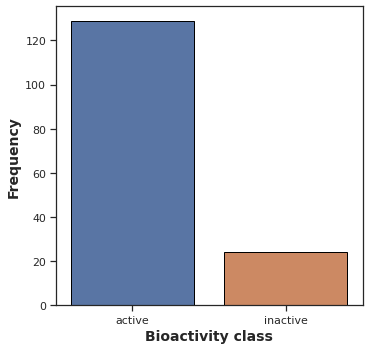

In [35]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('tryptase_plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

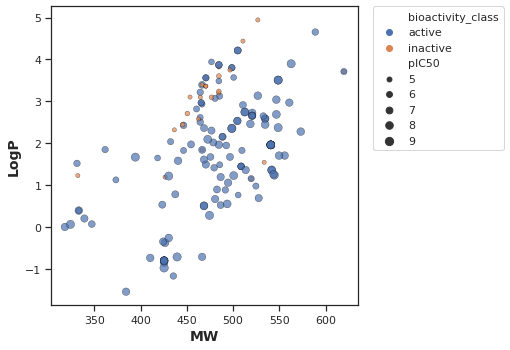

In [36]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('tryptase_plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**
If pIC50 value is > 6, the compound is active. 
If pIC50 is < 5, the compound is inactive.

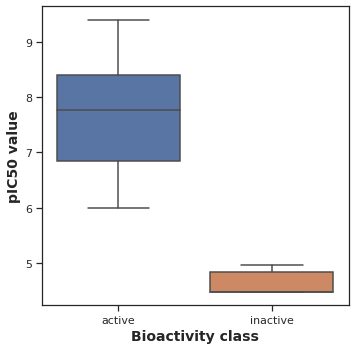

In [39]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('tryptase_plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**
This test is used to see the difference between the active and inactive compounds. Is there a statistical significant difference between active and inactive compounds?

In [41]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [42]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,3.880573e-15,0.05,Different distribution (reject H0)


#### **MW**

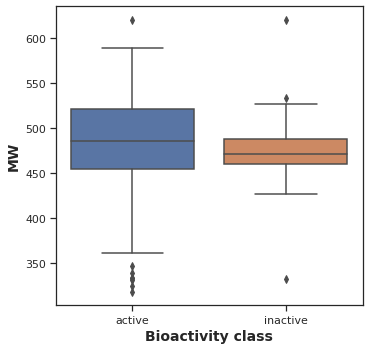

In [43]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('tryptase_plot_MW.pdf')

In [44]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1342.5,0.151846,0.05,Same distribution (fail to reject H0)


#### **LogP**

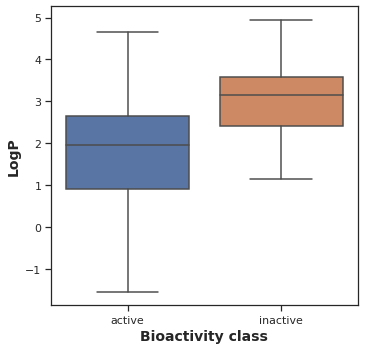

In [45]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('tryptase_plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [46]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,775.5,0.000054,0.05,Different distribution (reject H0)


#### **NumHDonors**

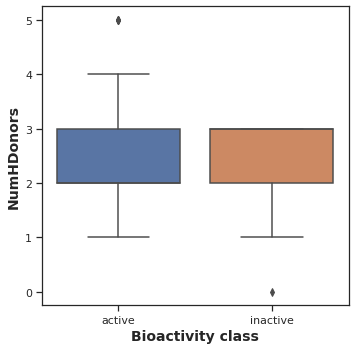

In [47]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('tryptase_plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [48]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1536.5,0.476589,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

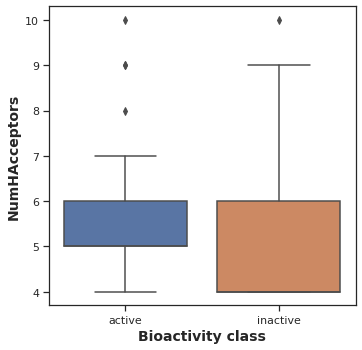

In [49]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('tryptase_plot_NumHAcceptors.pdf')

In [50]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1058.0,0.005398,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), MW and NumHDonors exhibited ***no difference*** between the **actives** and **inactives** while the other 2 descriptors (LogP and NumHAcceptors) shows ***statistically significant difference*** between **actives** and **inactives**.

## **Zip files**

In [51]:
! zip -r results.zip . -i *.csv *.pdf

  adding: tryptase_plot_NumHAcceptors.pdf (deflated 37%)
  adding: tryptase_plot_ic50.pdf (deflated 37%)
  adding: tryptase_plot_MW_vs_LogP.pdf (deflated 14%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 12%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: mannwhitneyu_LogP.csv (deflated 7%)
  adding: tryptase_bioactivity_preprocessed_data.csv (deflated 85%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 10%)
  adding: mannwhitneyu_pIC50.csv (deflated 11%)
  adding: tryptase_plot_bioactivity_class.pdf (deflated 38%)
  adding: tryptase_plot_LogP.pdf (deflated 38%)
  adding: tryptase_plot_NumHDonors.pdf (deflated 38%)
  adding: tryptase_plot_MW.pdf (deflated 39%)
